## <center>  Notebook S06. Size Distribution Inversion of Ambient Data </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook demonstrates how to use JDL to invert size distribution data obtained from the TSI Aerosol Instrument Manager (AIM) software. The notebook also demonstrates that the software produces comparable results to the TSI software. This notebook is a supplement to the manuscript  <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, LambertW, ProgressMeter, DifferentialMobilityAnalyzers
plotlyjs(); 

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup the DMA 
Sheath flow = 4 L min-1 and sample aerosol flow = 1 L min-1 and specified in the data file loaded below.

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/4                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 0.0                                       # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical) # Specify DMA with negative polarity
tscan, tc = 120,1                                # SMPS scan time, bin average time
v1,v2 = 10,10000                                 # Voltage range
z1,z2 = vtoz(Λ,v2), vtoz(Λ,v1)
δ = setupSMPS(Λ, v1, v2, tscan, tc);

## Block 3. Response function
<b> loadtsidata </b> Loads txt file exported from TSI Aerosol Instrument Manager (20130618_1410_SMPS3_BP.txt). The file was edited to remove a unicode character in line 154 that results in a load error. The load function will need to be adapted for files with different scan length and export parameters. The data corresponds to ambient data collected by Dr. Grieshop and Saha during the SOAS campaign (alse see Acknowledgements). It contains a total of 160 spectra. The instrument was operated at 4 L min-1 sheath flow and 1 L min-1 sample flow with a TSI 3081 long column DMA and TSI 3010 CPC. The data were exported with multiple charge correction turned on and diffusion correction turned off.  <br>
𝕟: Array of TSI inverted size distribution <br>
rawdp: raw diameter grid obtained at 10Hz acquisition <br>
rawc: 2D array containing raw counts vs diameter for each spectrum <br>
Nt_TSI: array of integrated number concentration computed by TSI software

In [3]:
𝕟, rawdp, rawc, Nt_TSI = loadtsidata();

The response function is computed from the 10 Hz raw count data. The raw counts falling within a bin are summed together. Concentration is computed from the number of milliseconds in each bin. The coincidence corrected concentration is obtained using Eq. (11) in Collins et al. (2003) <br><br>

<center> $N_a = \frac{-W(-N_m Q_{cpc}\tau)}{Q_{cpc}\tau}$ </center> 

where $N_a$ is the coincidence corrected concentration, $N_m$ is the measured raw concentration, $Q_{cpc}$ is the volumetric CPC flow rate, $\tau$ is the beam transit time, and $W$ is the zero branch of the LambertW function. Here $\tau = 0.4\mu s$, where the value is for the TSI 3010 CPC and obtained from the manufacturer manual.

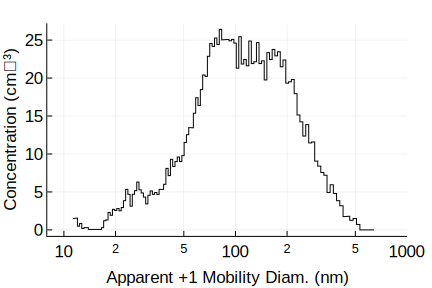

In [4]:
Qcpc,τ = 16.6666, 0.4e-6   # 1 L min-1 = 16.6666 cm3 s-1, 0.4 μs 
correct = @. x -> -lambertw(-x*Qcpc*τ,0)/(Qcpc*τ)

a,b = size(rawc)
𝕣 = SizeDistribution[]
for j = 1:b
    R = Float64[]
    for i = 1:length(δ.De)-1
        ii = (rawdp .<= δ.De[i]) .& (rawdp .> δ.De[i+1])
        un = rawdp[ii]
        c = rawc[ii,j]
        Nm = length(c) > 0 ? sum(c)./(length(c)*1.6666) : 0
        Na = correct(Nm)
        push!(R,Na)
    end
    push!(𝕣, SizeDistribution([],δ.De,δ.Dp,δ.ΔlnD,R./δ.ΔlnD,R,:raw))
end

j = 110  # plot example distribtution
figure("Nimbus Sans L", 2, 3, 2, 8)
p = plot(𝕣[j].Dp, 𝕣[j].N,xaxis = :log10,xticks = [10, 100, 1000],lt = :steppre,legend = :none,color = :black,
    ylabel = "Concentration (cm⁻³)", xlim = (8,1000), xlabel = "Apparent +1 Mobility Diam. (nm)", 
    right_margin = 25px, fmt = :svg)

<b> Figure 1.</b> Coincidence corrected size distribution obtained from raw counts.

## Block 4. Inversion using regularization
Theory of the inversion is presented in detail in Notebook S3. Here, the same routines are applied to actual data. The block makes use of the wrapper function rinv(), which computes the inverse of a response function and returns a size distribution
```julia
function rinv(R, δ;λ₁= 1e-2, λ₂=1e1)
    eyeM = Matrix{Float64}(I, length(R), length(R))
    setupRegularization(δ.𝐀,eyeM,R,inv(δ.𝐒)*R) # setup the system
    λopt = lcorner(λ₁,λ₂;n=10,r=3)                  # compute the optimal λ
    N =  clean((reginv(λopt, r = :Nλ))[1])          # find the inverted size
    return SizeDistribution([],δ.De,δ.Dp,δ.ΔlnD,N./δ.ΔlnD,N,:regularized)
end
```

In [5]:
λ₁,λ₂ = 1e-2, 1e1  # bounds [λ₁,λ₂] within which the optimal distribution lies

𝕟ᵢₙᵥ = SizeDistribution[]
@showprogress 1 "Inverting TSI SMPS ..." for i = 1:b
    push!(𝕟ᵢₙᵥ, rinv(𝕣[i].N, δ,λ₁=λ₁,λ₂=λ₂))
end

# Compute size distribution statistics.
Nt, Ninv = Float64[],Float64[]
At, Ainv = Float64[],Float64[]
Vt, Vinv = Float64[],Float64[]
for i = 1:b
    push!(Nt,  sum(𝕟[i].N))
    push!(Ninv,sum(𝕟ᵢₙᵥ[i].N))
    push!(At,  sum(π/4.0.*(𝕟[i].Dp./1000.0).^2 .* 𝕟[i].N))
    push!(Ainv,sum(π/4.0.*(𝕟ᵢₙᵥ[i].Dp./1000.0).^2 .* 𝕟ᵢₙᵥ[i].N))
    push!(Vt,  sum(π/6.0.*(𝕟[i].Dp./1000.0).^3 .* 𝕟[i].N))
    push!(Vinv,sum(π/6.0.*(𝕟ᵢₙᵥ[i].Dp./1000.0).^3 .* 𝕟ᵢₙᵥ[i].N))
end

Inverting TSI SMPS ...100%|█████████████████████████████| Time: 0:03:52


## Block 5. Visualization

### (a) Example size distribution comparison

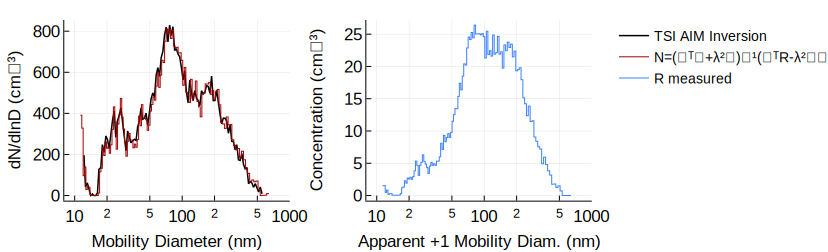

In [6]:
figure("Nimbus Sans L", 2, 5.75, 1.75, 8)

p2 = plot(𝕟[j].Dp, 𝕟[j].S, xaxis = :log10, xticks = [10, 100, 1000],
    ylabel = "dN/dlnD (cm⁻³)", label = "TSI AIM Inversion", xlim = (8,1000),  
    color = :black, xlabel = "Mobility Diameter (nm)", left_margin = 30px, lw= 1.5)

p2 = plot!(𝕟ᵢₙᵥ[j].Dp, 𝕟ᵢₙᵥ[j].S, color = RGBA(163/255,0,0,1),
    lt = :steppre, label = "N=(𝐀ᵀ𝐀+λ²𝐈)⁻¹(𝐀ᵀR-λ²𝐒⁻¹R)", xlim = (8,1000))

p3 = plot(𝕣[j].Dp, 𝕣[j].N, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre,
    label = "R measured", ylabel = "Concentration (cm⁻³)", xlim = (8,1000),left_margin = 30px,
    color = RGBA(58/255,129/255,252/255,1), xlabel = "Apparent +1 Mobility Diam. (nm)")

plot(p2,p3, layout = grid(1,2), right_margin = 30px, top_margin = 0px, fmt = :svg)

<b> Figure 2.</b> Left: Size distribution expressed as dN/dlnD output by TSI AIM software and the inversion performed in Block 3. Right: Measured response function as shown in Figure 1.

### (b) Comparison of integrated number, area, and volume concentration

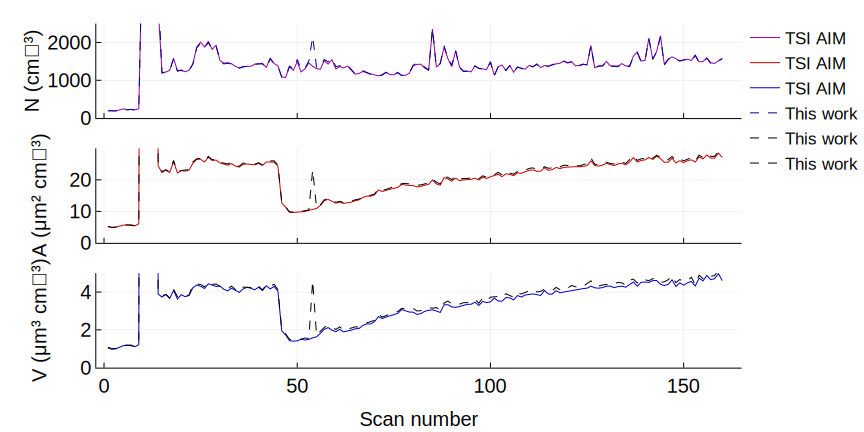

In [7]:
figure("Nimbus Sans L", 2, 6, 3, 10)

p1 = plot(Nt, ylabel = "N (cm⁻³)", label = "TSI AIM",ylim = (0,2500), color = RGBA(0.6,0,0.6,1))
p1 = plot!(Ninv, ylabel = "N (cm⁻³)", label = "This work", ytick = [0,1000, 2000],
    color = RGBA(0,0,0.6,1), ls = :dash, xticks = ([0,50,100,150],["","","",""]))

p2 = plot(At, ylabel = "A(μm² cm⁻³)", label = "TSI AIM", ylim = (0,30), color = RGBA(0.8,0,0,1))
p2 = plot!(Ainv, ylabel = "A (μm² cm⁻³)", label = "This work",  ytick = [0, 10, 20],
    color = RGBA(0,0,0,1), ls = :dash, xticks = ([0,50,100,150],["","","",""]))

p3 = plot(Vt, ylabel = "V(μm³ cm⁻³)", label = "TSI AIM", ylim = (0,5), color = RGBA(0.0,0,0.8,1))
p3 = plot!(Vinv, ylabel = "V (μm³ cm⁻³)", label = "This work", xlabel = "Scan number", 
    color = RGBA(0,0,0,1), ls = :dash, ytick = [0,2,4],xticks = [0,50,100,150])


plot(p1,p2,p3, layout = grid(3,1), left_margin = 30px, bottom_margin = 10px, xlim = (-2,165), fmt = :svg)

<b> Figure 3.</b> Top to bottom: integrated number concentration, surface area, and volume concentration from TSI AIM software provided dn/dlnD distribution and from the inversion of this work. Note that for scan 54, the agreement is poor. The spectrum can be visualized using the block above if desired. The disagreement is due to failed convergence of the L-curve algorithm. This can be fixed by changing the bounds $\lambda_1$ and $\lambda_2$ in the lcorner() call or perhaps a more robust L-curve algorithm. It is left in place here to alert potential users of this issue. It is apparent from graphing the inverted spectra from scan 54 that inversion failed.

### (c) Comparison of relative error

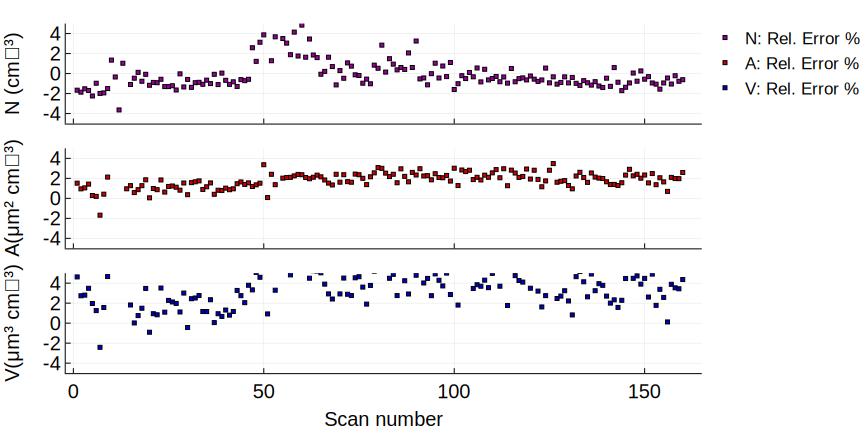

In [8]:
figure("Nimbus Sans L", 2, 6, 3, 10)

p1 = plot(100*(Ninv - Nt)./Nt, ylabel = "N (cm⁻³)", 
    label = "N: Rel. Error %", color = RGBA(0.6,0,0.6,1), marker = :square,
    xticks = ([0,50,100,150],["","","","",""]))
p2 = plot(100*(Ainv - At)./At, ylabel = "A(μm² cm⁻³)", 
    label = "A: Rel. Error %", color = RGBA(0.8,0,0,1), marker = :square,
    xticks = ([0,50,100,150],["","","","",""]))
p3 = plot(100*(Vinv - Vt)./Vt, ylabel = "V(μm³ cm⁻³)", xlabel = "Scan number",
    label = "V: Rel. Error %", color = RGBA(0,0,0.8,1), marker = :square)

plot(p1,p2,p3, layout = grid(3,1), left_margin = 30px, ylim = (-5,5), 
    ms = 2, lw = 0, ytick = [-4, -2, 0, 2, 4], xlim = (-2,165), fmt = :svg)

<b> Figure 4.</b> Top to bottom: relative error in integrated number concentration, surface area, and volume concentration between TSI AIM software provided dn/dlnD distribution and from the inversion of this work.

## Summary and Conclusions
Figures 2-4 demonstrate that the code can be used to invert size distribution data. Figure 2 shows that the inverted spectra is in good qualitative agreement with the inverted spectra from the TSI software. The error of the  regularization routine here appears to be similar to that of the TSI algorithm. Number surface area, and volume concentration agree within ~2%, 2%, and 4% for the entire dataset. This agreement is comparable to the range given by Wiedensohler et al. (2012), who compared the performance of several commercial and non-commercial inversion routines. 

## Acknowlegements and References

The data were collected by Drs. Andrew Grieshop and Provat Saha during the 2013 SOAS campaign (Saha et al., 2017). I thank Andrew Grieshop for sharing the datafile. <br>

Collins, A. M.,  W. D. Dick & F. J. Romay (2013) A New Coincidence Correction Method for Condensation Particle Counters, Aerosol Science and Technology, 47:2, 177-182, DOI:10.1080/02786826.2012.737049

Reineking A. & J. Porstendörfer (1986) Measurements of Particle Loss Functions in a Differential Mobility Analyzer (TSI, Model 3071) for Different Flow Rates, Aerosol Science and Technology, 5:4, 483-486, DOI:10.1080/02786828608959112

Saha, P. K., Khlystov, A., Yahya, K., Zhang, Y., Xu, L., Ng, N. L., and Grieshop, A. P.: Quantifying the volatility of organic aerosol in the southeastern US, Atmos. Chem. Phys., 17, 501-520, https://doi.org/10.5194/acp-17-501-2017, 2017. 

Wiedensohler, A., Birmili, W., Nowak, A., Sonntag, A., Weinhold, K., Merkel, M., Wehner, B., Tuch, T., Pfeifer, S., Fiebig, M., Fjäraa, A. M., Asmi, E., Sellegri, K., Depuy, R., Venzac, H., Villani, P., Laj, P., Aalto, P., Ogren, J. A., Swietlicki, E., Williams, P., Roldin, P., Quincey, P., Hüglin, C., Fierz-Schmidhauser, R., Gysel, M., Weingartner, E., Riccobono, F., Santos, S., Grüning, C., Faloon, K., Beddows, D., Harrison, R., Monahan, C., Jennings, S. G., O'Dowd, C. D., Marinoni, A., Horn, H.-G., Keck, L., Jiang, J., Scheckman, J., McMurry, P. H., Deng, Z., Zhao, C. S., Moerman, M., Henzing, B., de Leeuw, G., Löschau, G., and Bastian, S.: Mobility particle size spectrometers: harmonization of technical standards and data structure to facilitate high quality long-term observations of atmospheric particle number size distributions, Atmos. Meas. Tech., 5, 657-685, https://doi.org/10.5194/amt-5-657-2012, 2012. 